In [40]:
# Strategy 1:
# Generate data after each epoch of training, if less than
# 10% error rate, and is a legit SMILES
# append to the real data
# Otherwise, append to fake data

# ADDING REINFORCEMENT MECHANISM
# Regenerate Normal sampling (define ranges), default: uniform

# IMPORTANT!!!!!!!!!!!!! DO NOT DROP DUPLICATE FOR RESULT .CSV

import warnings
warnings.filterwarnings('ignore')

import time
import os
import re
import pandas as pd
import random

import matplotlib as mpl
from matplotlib import rc, rcParams

import numpy as np
from numpy import ndarray

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from scipy.stats import truncnorm

import multiprocessing
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Input, Dropout, LSTM, Reshape, LeakyReLU,
                          Concatenate, ReLU, Flatten, Dense, Embedding,
                          BatchNormalization, Activation, SpatialDropout1D,
                          Conv2D, MaxPooling2D, UpSampling2D, Lambda)
from tensorflow.keras.models     import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses     import mse, binary_crossentropy
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import  mean_squared_error as mse_keras
from tensorflow.keras.backend import argmax as argmax
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import one_hot
from tensorflow.keras.models import Sequential 

from tensorflow.keras.utils import  to_categorical
from tensorflow import random as randomtf

from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
from   matplotlib.lines import Line2D
from   matplotlib.colors import ListedColormap
import matplotlib.ticker as tk

from progressbar import ProgressBar
import seaborn as sns

from chainer_chemistry.dataset.preprocessors import GGNNPreprocessor, construct_atomic_number_array
preprocessor = GGNNPreprocessor()
from rdkit import rdBase
rdBase.DisableLog('rdApp.error')
from rdkit import Chem
import rdkit.Chem.rdchem as rdchem


import ntpath
from scipy.stats import truncnorm

""" fix all the seeds,results are still slighthly different """
randomtf.set_seed(10)
os.environ['PYTHONHASHSEED'] = '10'
np.random.seed(420)
random.seed(123450)
from progressbar import ProgressBar

gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.4)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1, gpu_options=gpu_options)
tf.compat.v1.set_random_seed(1234)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.3667)
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1, gpu_options=gpu_options)
#tf.set_random_seed(1234)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)

2023-05-24 10:05:18.901628: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-24 10:05:18.901850: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-24 10:05:18.901968: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-24 10:05:18.902108: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-24 10:05:18.902173: I tensorflow/compiler/xla/stream_executo

Text(0.5, 0, '!!!Ariaaaal')

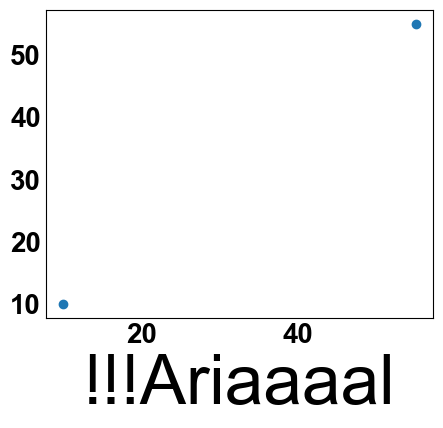

In [2]:
# check the font !!!!!!!!!!!!!!!!!!!!!
# switch to Arial
# if not working: delet ~/.catch/matplotlib
plt.rcParams["font.family"] = "Arial"
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.fonttype'] = 42
mpl.font_manager.FontManager()

rc('font', weight='bold')
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter([10, 55], [10, 55])
ax.tick_params(axis='both', length=0, width=1.5, colors='black', grid_alpha=0, labelsize=20)
plt.xlabel('!!!Ariaaaal', fontname='Arial', fontsize=50)

In [3]:
""" reading and preprocessing data"""
with open('./../data/trainingsets/60000_train_regular_pubqc/image_train.pickle', 'rb') as f:
    X_smiles_train0, SMILES_train0, y_train00 = pickle.load(f)
    
with open('./../data/trainingsets/60000_train_regular_pubqc/image_test.pickle', 'rb') as f:
    X_smiles_val0, SMILES_val0, y_val00 = pickle.load(f)

with open('./../data/trainingsets/60000_train_regular_pubqc/tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)
tokenizer[0] = ' '

print (X_smiles_train0.shape)
print (X_smiles_val0.shape)

(106101, 40, 27, 1)
(24819, 40, 27, 1)


In [4]:
# reduce the number of samples
# subsampling
idx = np.random.choice(len(y_train00), int(len(y_train00) * 0.0185), replace = False)

X_smiles_train, SMILES_train, y_train0 = (X_smiles_train0[idx], SMILES_train0[idx], y_train00[idx])


idx = np.random.choice(len(y_val00), int(len(y_val00) * 0.01), replace = False)

X_smiles_val, SMILES_val, y_val0 = (X_smiles_val0[idx], SMILES_val0[idx], y_val00[idx])

print (X_smiles_train.shape)
print (X_smiles_val.shape)

(1962, 40, 27, 1)
(248, 40, 27, 1)


In [5]:
y_train0.shape

(1962,)

In [6]:
# Standardized between 0 and 11
gap_min = 0
gap_max = 11
y_val   = (y_val0 -   gap_min) / (gap_max - gap_min)
y_train = (y_train0 - gap_min) / (gap_max - gap_min)

print (np.max(y_val))
print (np.max(y_train0))

0.9152727272727272
10.901


<Axes: ylabel='Count'>

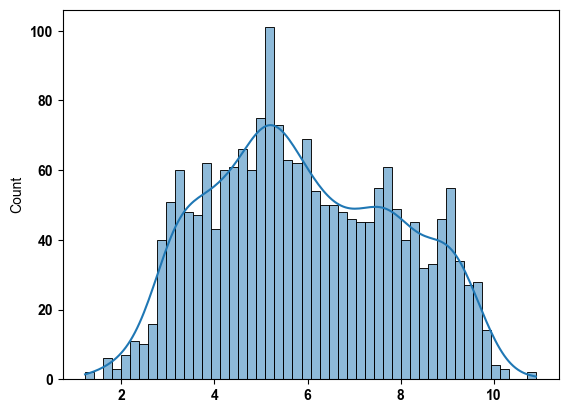

In [7]:
sns.histplot(y_train0, bins=50, kde=True,)

In [8]:
""" Training RCGAN """
encoder = load_model('./../data/nns/keep/encoder.h5')
decoder = load_model('./../data/nns/keep/decoder.h5')
regressor = load_model    ('./../data/nns/keep/regressor.h5')
regressor_top = load_model('./../data/nns/keep/regressor_top.h5')
generator = load_model    ('./../data/nns/keep/generator.h5')
discriminator= load_model ('./../data/nns/keep/discriminator.h5') 

2023-05-24 10:02:31.673989: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-24 10:02:31.674164: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-24 10:02:31.674224: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-24 10:02:31.674446: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-24 10:02:31.674537: I tensorflow/compiler/xla/stream_executo

In [9]:
"""
pbar = ProgressBar()
max = 0.3

randS = []
rsquaredS = []
MAE_S = []
less20RE_perS = []
output_lenS = []
mean_RE_S = []
outputs = pd.DataFrame({})
gen_atoms_embeddings = []
gen_bonds_embeddings = []

for rand in pbar([0]):  
    N = 150
    n_sample = 200
    gen_error = []
    gen_smiles = []
    sample_ys = []
    preds = []
    gen_atoms_embedding = []
    gen_bonds_embedding = []

    regressor_top.trainable = False
    regressor.trainable = False
    generator.trainable = False
    discriminator.trainable = False

    np.random.seed(rand)
    
    pbar = ProgressBar()

    for sample in (pbar(y_train00)):
        try:
            # get it back to original of s_min to s_max
            #sample_y = np.random.uniform(0, 10.7, size=[1,])

            sample_y = sample
            #print (sample_y)
            sample_y = np.round(sample_y, 4)
            sample_y = sample_y * np.ones([N, ])
            sample_y_ = (sample_y - gap_min) / (gap_max - gap_min)
            sample_z = np.random.normal(0, 1, size = (N, 128))

            regressor_top.trainable = False
            regressor.trainable = False

            sample_atoms_embedding, sample_bonds_embedding = generator.predict([sample_z, sample_y_], verbose=0)
            dec_embedding = np.concatenate([sample_atoms_embedding, sample_bonds_embedding], axis = -1)

            softmax_smiles = decoder.predict(dec_embedding, verbose=0)[0]
            argmax_smiles = np.argmax(softmax_smiles, axis = 2)
            #print ('shape argmax_smiles', argmax_smiles.shape)
            smiles = to_categorical(argmax_smiles, num_classes=27)
            SHAPE = list(smiles.shape) + [1] 
            #print ('shape line 767', SHAPE) 
            smiles = smiles.reshape(SHAPE)

            latent_encoder_atom, latent_encoder_bond, _ = encoder.predict([smiles], verbose=0)
            pred = regressor.predict([latent_encoder_atom, latent_encoder_bond], verbose=0).reshape([-1])
            pred = pred * (gap_max - gap_min) + gap_min

            gen_errors = np.abs((pred - sample_y) / sample_y).reshape([-1])


            smiles = decoder.predict(dec_embedding, verbose=0)[0]
            smiles = np.argmax(smiles, axis = 2).reshape(smiles.shape[0], 40)

            generated_smiles = []
            for S in smiles:
                c_smiles = ''
                for s in S:
                    c_smiles += tokenizer[s]
                c_smiles = c_smiles.rstrip()
                generated_smiles.append(c_smiles)
            generated_smiles = np.array(generated_smiles)
            #generated_smiles = generated_smiles [accurate]
            all_gen_smiles = []
            idx = []
            for i, smiles in enumerate(generated_smiles):
                all_gen_smiles.append(smiles[:-1])

                if ' ' in smiles[:-1]:
                    continue
                #m = Chem.MolFromSmiles(smiles[:-1], sanitize=False)
                m = Chem.MolFromSmiles(smiles[:-1], sanitize=True)
                if m is not None:
                    if len(construct_atomic_number_array(m)) <= 60:
                        idx.append(i)

            idx = np.array(idx)
            all_gen_smiles = np.array(all_gen_smiles)
            #print ('all gen smiels shape', all_gen_smiles.shape)
            #print ('gen_errors shape', gen_errors.shape)
            #print (idx)
            gen_smiles.extend(list(all_gen_smiles[idx]))
            gen_error.extend(list(gen_errors[idx]))
            sample_ys.extend(list(sample_y[idx]))
            gen_atoms_embedding.extend(sample_atoms_embedding[idx])
            gen_bonds_embedding.extend(sample_bonds_embedding[idx])
            preds.extend(list(pred[idx]))
        except:
            #print('Did not discover SMILES for HC: {}'.format(sample_y))
            pass    


    output = {}

    for i, s in enumerate (gen_smiles):
        ss = Chem.MolToSmiles(Chem.MolFromSmiles(s, sanitize=True))
        gen_smiles[i] = ss

    output['SMILES'] = gen_smiles
    output['des_gap'] = sample_ys
    output['pred_gap'] = preds
    output['Err_pred_des'] = gen_error
    output = pd.DataFrame(output)
    output.reset_index(drop = True, inplace = True)
    #output.to_csv ('./../experiments/regular/Initial_training.csv', index=False)

    ## Statistics  (# pred=True value, Des=prediction)
    # total # of samples
    N = len(gen_error)
    print ('random seed', rand)

    # Explained Variance R2 from sklearn.metrics.explained_variance_score
    explained_variance_R2_pred_des = explained_variance_score(output['des_gap'], output['pred_gap'])
    print ("explained_varice_R2_pred_des", explained_variance_R2_pred_des)
    rsquared = np.round (r2_score (output['des_gap'], output['pred_gap']), 4)
    print ("r squared r**2", rsquared)

    # mean absolute error 
    MAE_pred_des = np.round (mean_absolute_error(output['pred_gap'], output['des_gap']), 4)
    print ("MAE_pred_des", MAE_pred_des)
    # Fractioned MAE, more normalized
    Fractioned_MAE_pred_des = 0
    for pred, des in zip(output['pred_gap'], output['des_gap']):
        Fractioned_MAE_pred_des = Fractioned_MAE_pred_des +  abs(des-pred)/des
    Fractioned_MAE_pred_des = Fractioned_MAE_pred_des/N
    #print ("Fractioned MAE_pred_des", Fractioned_MAE_pred_des)

    # root mean squared error (RMSE), sqrt(sklearn ouputs MSE)
    RMSE_pred_des = mean_squared_error(output['pred_gap'], output['des_gap'])**0.5
    #print ("RMSE_pred_des", RMSE_pred_des)

    Fractioned_RMSE_pred_des = 0
    for pred, des in zip(output['pred_gap'], output['des_gap']):
        Fractioned_RMSE_pred_des = Fractioned_RMSE_pred_des + ((des-pred)/des)**2
    Fractioned_RMSE_pred_des = (Fractioned_RMSE_pred_des/N)**0.5
    #print ("Fractioned_RMSE_pred_des", Fractioned_RMSE_pred_des)

    # do not drop duplicate
    output2 = output.drop_duplicates(['SMILES'])
    output2.reset_index(drop = True, inplace = True)
    
    with open('gen_pickles.pickle', 'wb') as f:
        pickle.dump(gen_unique_pickles, f)
    
    #print ('% < 20 RE NODUP', sum (output2['Err_pred_des'] < 0.2) / output2['Err_pred_des'].shape[0])
    less20RE_per = np.round ((sum(output['Err_pred_des'] <= 0.2) / output['Err_pred_des'].shape[0]), 4)
    print ('% < 20 RE', less20RE_per)
    output_len = len(output)
    explained_variance_R2_pred_des = explained_variance_score(output['des_gap'], output['pred_gap'])
    #print ("explained_varice_R2_pred_des", explained_variance_R2_pred_des)
    mean_RE = np.round (np.mean (output['Err_pred_des']), 4)
    print ('RE mean', mean_RE)

    randS.append(rand)
    rsquaredS.append(rsquared)
    MAE_S.append(MAE_pred_des)
    less20RE_perS.append(less20RE_per)
    mean_RE_S.append(mean_RE)
    output_lenS.append(output_len)

    if rsquared>max:
        good_rand = rand
        max = rsquared
        best_r2 = rsquared
        print ('best r2', best_r2)
        print ('best random seed', good_rand)
    
    tf.compat.v1.keras.backend.clear_session()
    outputs = pd.concat((outputs, output))
    gen_atoms_embeddings.extend(gen_atoms_embedding)
    gen_bonds_embeddings.extend(gen_bonds_embedding)

params = {}
params ['rand'] = randS
params ['r2'] = rsquaredS
params ['MAE'] = MAE_S
params ['less20RE_per'] = less20RE_perS
params ['Average_RE'] = mean_RE_S
params ['total_valid'] = output_lenS
params = pd.DataFrame(params)
params.reset_index(drop = True, inplace = True)
params.to_csv ('./gen_params.csv', index=False)
"""

'\npbar = ProgressBar()\nmax = 0.3\n\nrandS = []\nrsquaredS = []\nMAE_S = []\nless20RE_perS = []\noutput_lenS = []\nmean_RE_S = []\noutputs = pd.DataFrame({})\ngen_atoms_embeddings = []\ngen_bonds_embeddings = []\n\nfor rand in pbar([0]):  \n    N = 150\n    n_sample = 200\n    gen_error = []\n    gen_smiles = []\n    sample_ys = []\n    preds = []\n    gen_atoms_embedding = []\n    gen_bonds_embedding = []\n\n    regressor_top.trainable = False\n    regressor.trainable = False\n    generator.trainable = False\n    discriminator.trainable = False\n\n    np.random.seed(rand)\n    \n    pbar = ProgressBar()\n\n    for sample in (pbar(y_train00)):\n        try:\n            # get it back to original of s_min to s_max\n            #sample_y = np.random.uniform(0, 10.7, size=[1,])\n\n            sample_y = sample\n            #print (sample_y)\n            sample_y = np.round(sample_y, 4)\n            sample_y = sample_y * np.ones([N, ])\n            sample_y_ = (sample_y - gap_min) / (gap_

In [10]:
"""
with open('./../experiments/regular/latent/gen_atoms_bonds.pickle', 'wb') as f:
    pickle.dump((gen_atoms_embedding, gen_bonds_embedding), f)

output = pd.DataFrame(output)
output.reset_index(drop = True, inplace = True)
output.to_csv ('./../experiments/regular/latent/Regular.csv', index=False)
"""

"\nwith open('./../experiments/regular/latent/gen_atoms_bonds.pickle', 'wb') as f:\n    pickle.dump((gen_atoms_embedding, gen_bonds_embedding), f)\n\noutput = pd.DataFrame(output)\noutput.reset_index(drop = True, inplace = True)\noutput.to_csv ('./../experiments/regular/latent/Regular.csv', index=False)\n"

In [11]:
"""
with open('./../experiments/regular/latent/gen_sample20K/gen_atoms_bonds.pickle', 'wb') as f:
    pickle.dump((gen_atoms_embeddings, gen_bonds_embeddings), f)

outputs = pd.DataFrame(outputs)
outputs.reset_index(drop = True, inplace = True)
outputs.to_csv ('./../experiments/regular/latent/gen_sample20K/Regular.csv', index=False)
"""

"\nwith open('./../experiments/regular/latent/gen_sample20K/gen_atoms_bonds.pickle', 'wb') as f:\n    pickle.dump((gen_atoms_embeddings, gen_bonds_embeddings), f)\n\noutputs = pd.DataFrame(outputs)\noutputs.reset_index(drop = True, inplace = True)\noutputs.to_csv ('./../experiments/regular/latent/gen_sample20K/Regular.csv', index=False)\n"

In [12]:
# read the generated data
csv_name = './../experiments/regular/latent/Regular.csv'
gen_SMILES = pd.read_csv(csv_name)
output = gen_SMILES.copy()
gen_smiles = gen_SMILES ['SMILES']
sample_ys = gen_SMILES ['des_gap']
preds = gen_SMILES ['pred_gap']
gen_error = gen_SMILES ['Err_pred_des']

with open('./../experiments/regular/latent/gen_atoms_bonds.pickle', 'rb') as f:
    gen_atoms_embedding, gen_bonds_embedding = pickle.load(f)

In [13]:
gen_SMILES

,SMILES,des_gap,pred_gap,Err_pred_des
0,CCCC1CCOC(C=O)C1C,6.8140,6.566881,0.036266
1,CCC1CCCCCCCCCCCCN1,6.0845,7.366741,0.210739
2,CC1CCCCCCCCCCCCOC1C,9.7150,8.998064,0.073797
3,CCCCC(C)OC(C)CCC(C)CC,9.0040,8.986472,0.001947
4,CCN(C)CCC=C1CCCCCC(OC)CC1,4.7920,6.687652,0.395587
...,...,...,...,...
1921,CCCCCC1CCC2CCCC1CCC2,8.8110,9.127287,0.035897
1922,CCCC1CCCC(CC)CCCCCC(C)C1,9.6550,9.801198,0.015142
1923,C#CCCCC(C)CCC(C)CCCCC,9.0886,9.075156,0.001479
1924,CCCCCCC(C)O,9.6300,9.109724,0.054027


In [14]:
""""
# read the generated data
csv_name = './../experiments/regular/latent/gen_sample20K/Regular.csv'
gen_SMILES = pd.read_csv(csv_name)
output = gen_SMILES.copy()
with open('./../experiments/regular/latent/gen_sample20K/gen_atoms_bonds.pickle', 'rb') as f:
    gen_atoms_embedding0, gen_bonds_embedding0 = pickle.load(f)

# reduce the number of samples
# subsampling
outputs2 = pd.DataFrame(output)
# output = outputs2.copy()

index1 = np.random.choice(outputs2.loc[outputs2['pred_gap']>6].loc[outputs2['pred_gap']<9].index, 700, replace=False)
index2 = np.random.choice(outputs2.loc[outputs2['pred_gap']<3].index, outputs2.loc[outputs2['pred_gap']<3].index.shape[0], replace=False)

index3 = np.random.choice(outputs2.loc[outputs2['pred_gap']<4].loc[outputs2['pred_gap']>3].index, 
                          int(outputs2.loc[outputs2['pred_gap']<4].loc[outputs2['pred_gap']>3].index.shape[0]/2), replace=False)
index4 = np.random.choice(outputs2.loc[outputs2['pred_gap']<6].loc[outputs2['pred_gap']>4].index, 650, replace=False)
index5 = np.random.choice(outputs2.loc[outputs2['pred_gap']>9].index, 200, replace=False)
index = np.concatenate((index1, index2, index3, index4, index5))
index.shape

output = output.iloc[index]
output.shape

# read the generated data
gen_smiles = output ['SMILES']
sample_ys = output ['des_gap']
preds = output ['pred_gap']
gen_error = output ['Err_pred_des']

gen_atoms_embedding0 = np.array (gen_atoms_embedding0)
gen_bonds_embedding0 = np.array (gen_bonds_embedding0)

gen_atoms_embedding, gen_bonds_embedding = gen_atoms_embedding0[index], gen_bonds_embedding0[index]
"""

'"\n# read the generated data\ncsv_name = \'./../experiments/regular/latent/gen_sample20K/Regular.csv\'\ngen_SMILES = pd.read_csv(csv_name)\noutput = gen_SMILES.copy()\nwith open(\'./../experiments/regular/latent/gen_sample20K/gen_atoms_bonds.pickle\', \'rb\') as f:\n    gen_atoms_embedding0, gen_bonds_embedding0 = pickle.load(f)\n\n# reduce the number of samples\n# subsampling\noutputs2 = pd.DataFrame(output)\n# output = outputs2.copy()\n\nindex1 = np.random.choice(outputs2.loc[outputs2[\'pred_gap\']>6].loc[outputs2[\'pred_gap\']<9].index, 700, replace=False)\nindex2 = np.random.choice(outputs2.loc[outputs2[\'pred_gap\']<3].index, outputs2.loc[outputs2[\'pred_gap\']<3].index.shape[0], replace=False)\n\nindex3 = np.random.choice(outputs2.loc[outputs2[\'pred_gap\']<4].loc[outputs2[\'pred_gap\']>3].index, \n                          int(outputs2.loc[outputs2[\'pred_gap\']<4].loc[outputs2[\'pred_gap\']>3].index.shape[0]/2), replace=False)\nindex4 = np.random.choice(outputs2.loc[outputs2[\

In [15]:
## Statistics  (# DFT=True value, Des=prediction)
# total # of samples
N = len(gen_error)
# Explained Variance R2 from sklearn.metrics.explained_variance_score
explained_variance_R2_DFT_des = explained_variance_score(output['des_gap'], output['pred_gap'])
print ("explained_varice_R2_DFT_des", explained_variance_R2_DFT_des)
print ("r2", r2_score(output['des_gap'], output['pred_gap']))

# mean absolute error 
MAE_DFT_des = mean_absolute_error(output['pred_gap'], output['des_gap'])
print ("MAE_DFT_des", MAE_DFT_des)
# Fractioned MAE, more normalized
Fractioned_MAE_DFT_des = 0
for dft, des in zip(output['pred_gap'], output['des_gap']):
    Fractioned_MAE_DFT_des = Fractioned_MAE_DFT_des +  abs(des-dft)/dft
Fractioned_MAE_DFT_des = Fractioned_MAE_DFT_des/N
print ("Fractioned MAE_des_DFT", Fractioned_MAE_DFT_des)

# root mean squared error (RMSE), sqrt(sklearn ouputs MSE)
RMSE_DFT_des = mean_squared_error(output['pred_gap'], output['des_gap'])**0.5
print ("RMSE_DFT_des", RMSE_DFT_des)


explained_varice_R2_DFT_des 0.5073478629761876
r2 0.5071116615910304
MAE_DFT_des 1.1485157001038422
Fractioned MAE_des_DFT 0.2090270903559461
RMSE_DFT_des 1.459882260246362


<Axes: xlabel='pred_gap', ylabel='Percent'>

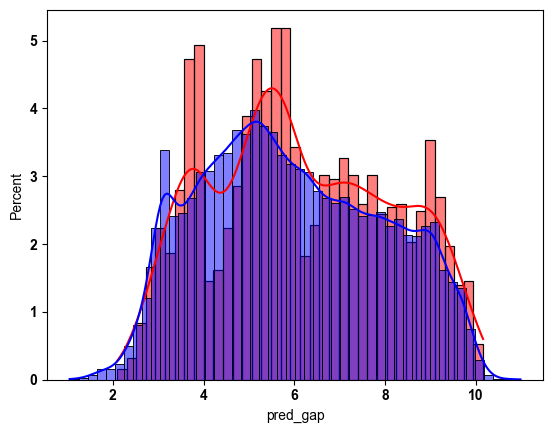

In [16]:
preds = output['pred_gap']
sns.histplot(preds, color='red', bins=38, stat='percent', kde=True)
sns.histplot(y_train00, color='blue', bins=50, stat='percent', kde=True)

In [17]:
gen_atoms_embedding.shape

(1926, 6, 6, 1)

In [18]:
output = pd.DataFrame(output)

gen_atoms_embedding = np.array(gen_atoms_embedding)
gen_bonds_embedding = np.array(gen_bonds_embedding)

preds = output['pred_gap']
# do not drop duplicate
gen_bonds_embedding.shape

# ANALYSIS
train_atoms_embedding, train_bonds_embedding, _ = encoder.predict([X_smiles_train]) 

X_atoms_train_ = train_atoms_embedding.reshape([train_atoms_embedding.shape[0], 6*6])
X_bonds_train_ = train_bonds_embedding.reshape([train_bonds_embedding.shape[0], 6*6])

X_atoms_test_ = gen_atoms_embedding.reshape([gen_atoms_embedding.shape[0], 6*6])
X_bonds_test_ = gen_bonds_embedding.reshape([gen_bonds_embedding.shape[0], 6*6])

""" PCA """
pca_1 = PCA(n_components = 2)
X_atoms_train = pca_1.fit_transform(X_atoms_train_)
X_atoms_test = pca_1.transform(X_atoms_test_)

pca_2 = PCA(n_components = 2)
X_bonds_train = pca_2.fit_transform(X_bonds_train_)
X_bonds_test = pca_2.transform(X_bonds_test_)

2023-05-24 10:02:34.505696: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-05-24 10:02:35.083838: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


62/62 [==============================] - 2s 2ms/step


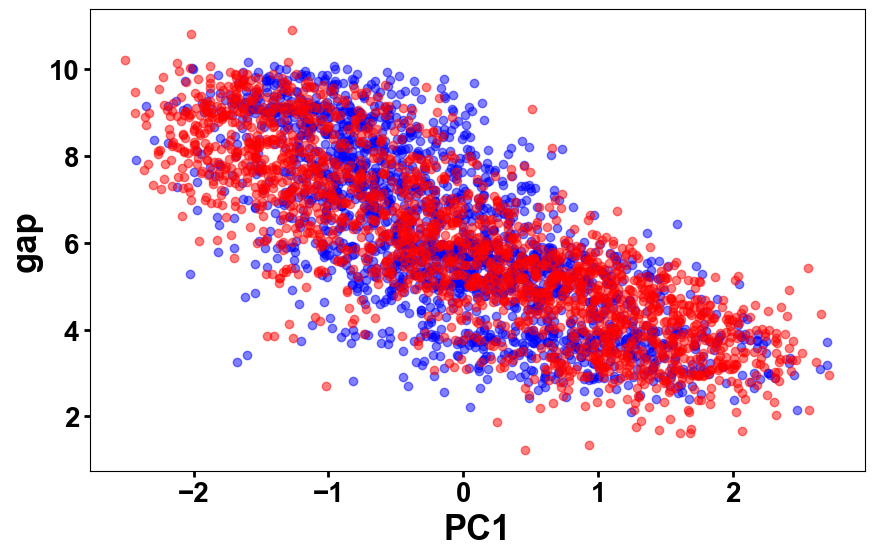

In [19]:
""" concat. latent vectors """
X_Concat_train =  np.concatenate ([X_bonds_train_, X_atoms_train_], axis=1)
X_Concat_test  =  np.concatenate ([X_bonds_test_, X_atoms_test_], axis=1)
pca_2 = PCA(n_components = 2)
X_concat_train_pca = pca_2.fit_transform(X_Concat_train)
X_concat_test_pca = pca_2.transform(X_Concat_test)

# PCA1 vs. gap gen. and train
plt.close()
fig, ax = plt.subplots(figsize =(10, 6))
ax.tick_params(axis='both', which='major', labelsize=20)
mpl.rcParams['axes.linewidth'] = 3.5
#preds_rev = [max(preds)-i for i in preds]
plt.scatter(X_concat_test_pca[:, 0], preds, alpha=0.5, color='blue')
#plt.legend(fontsize=12)
ax.tick_params(width=2, length=4)
plt.xlabel('PC1', fontsize=25, fontweight='bold')
plt.ylabel('gap', fontsize=25, fontweight='bold')
plt.scatter(X_concat_train_pca[:, 0], y_train0, color='red', alpha=0.5)
#plt.savefig("./genvstrain_Concat_pc1vsgap.png", bbox_inches='tight', dpi=500)

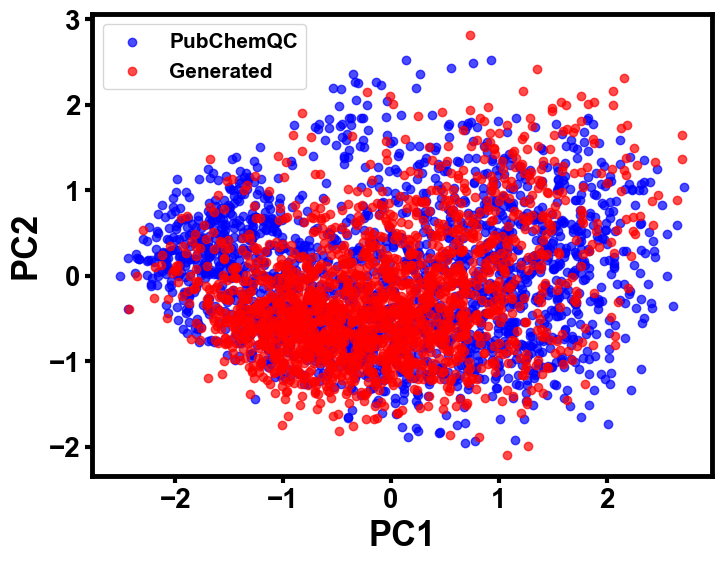

In [20]:
# PCA2 vs. gap gen and train
plt.close()
fig, ax = plt.subplots(figsize =(10, 6))
ax.tick_params(axis='both', which='major', labelsize=20)
mpl.rcParams['axes.linewidth'] = 3.5
#preds_rev = [max(preds)-i for i in preds]
plt.scatter(X_concat_test_pca[:, 1], preds, c='red')
#plt.legend(fontsize=12)
ax.tick_params(width=2, length=4)
plt.xlabel('PC2', fontsize=25, fontweight='bold')
plt.ylabel('gap', fontsize=25, fontweight='bold')
plt.scatter(X_concat_train_pca[:, 1], y_train0, c='blue')
#plt.savefig("./genvstrain_Concat_pc2vsgap.png", bbox_inches='tight', dpi=500)

# PCA1 vs. PCA2 gen and train
plt.close()
fig, ax = plt.subplots(figsize =(8, 6))
ax.tick_params(axis='both', which='major', labelsize=20)
mpl.rcParams['axes.linewidth'] = 3.5
plt.scatter(X_concat_train_pca[:, 0], X_concat_train_pca[:, 1], edgecolor=None, alpha=0.7, c='blue', label='PubChemQC')
ax.tick_params(width=3, length=5)
plt.xlabel('PC1', fontsize=25, weight='bold')
plt.ylabel('PC2', fontsize=25, weight='bold')
#plt.close()
plt.scatter(X_concat_test_pca[:, 0], X_concat_test_pca[:, 1], alpha=0.7, c='red', edgecolor=None, label='Generated')
plt.legend(fontsize=15, loc='upper left')
plt.savefig("./genvstrain_concat_pc1vspc2.png".format(len(preds)), bbox_inches='tight', dpi=500)

In [21]:
# use the same classes
Qs_gen = np.quantile(preds, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
Qs = np.quantile(y_train0, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
#Qs_gen = Qs
#Qs = Qs_gen
y_class_val = preds
y_class = y_train0
print ("quantile of train samples: ", Qs)
print ("quantile of train samples: ", Qs_gen)

# 4 classes: same # samples
y_class_val = np.where(preds <= (Qs_gen[1]+Qs_gen[2])/2, 0, y_class_val)
y_class_val = np.where((preds > (Qs_gen[1]+Qs_gen[2])/2) & (preds <= Qs_gen[4]), 1, y_class_val)
y_class_val = np.where((preds > Qs_gen[4]) & (preds <= (Qs_gen[6]+Qs_gen[7])/2), 2, y_class_val)
y_class_val = np.where(preds > (Qs_gen[6]+Qs_gen[7])/2, 3, y_class_val)

# 4 classes
y_class = np.where(y_train0 <= (Qs[1]+Qs[2])/2, 0, y_class)
y_class = np.where((y_train0 > (Qs[1]+Qs[2])/2) & (y_train0 <= Qs[4]), 1, y_class)
y_class = np.where((y_train0 > Qs[4]) & (y_train0 <= (Qs[6]+Qs[7])/2), 2, y_class)
y_class = np.where(y_train0 > (Qs[6]+Qs[7])/2, 3, y_class)

print ('gen class==0', sum(y_class_val==0))
print ('gen class==1', sum(y_class_val==1))
print ('gen class==2', sum(y_class_val==2))
print ('gen class==3', sum(y_class_val==3))

print ('train class==0', sum(y_class==0))
print ('train class==1', sum(y_class==1))
print ('train class==2', sum(y_class==2))
print ('train class==3', sum(y_class==3))

quantile of train samples:  [3.3363    4.0668    4.6991218 5.2093474 5.7224165 6.3692    7.1474
 7.8982    8.8541   ]
quantile of train samples:  [3.59232005 4.076665   4.991848   5.457828   5.8870913  6.650294
 7.34704585 8.127091   9.017307  ]
gen class==0 459
gen class==1 504
gen class==2 484
gen class==3 479
train class==0 489
train class==1 492
train class==2 487
train class==3 494


In [22]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
colors = ['navy', 'mediumblue','blue', 'cornflowerblue', 'lightsteelblue', 'lavender',
          'salmon', 'lightcoral', 'orangered', 'darkred']
colors = ['darkblue', 'lightsteelblue', 'orangered', 'darkred']

group_names = np.array(["E$_g$$_a$$_p$≤{}".format(np.round((Qs[1]+Qs[2])/2, 1)), 
                            f"{np.round((Qs[1]+Qs[2])/2, 1)}<E$_g$$_a$$_p$≤{np.round(Qs[4], 1)}",
                            "{}<E$_g$$_a$$_p$≤{}".format(np.round(Qs[4], 1), np.round((Qs[6]+Qs[7])/2, 1)),
                            "{}<E$_g$$_a$$_p$".format(np.round((Qs[6]+Qs[7])/2, 1))])
#group_names_gen = group_names
group_names_gen = np.array(["E$_g$$_a$$_p$≤{}".format(np.round((Qs_gen[1]+Qs_gen[2])/2, 1)), 
                            f"{np.round((Qs_gen[1]+Qs_gen[2])/2, 1)}<E$_g$$_a$$_p$≤{np.round(Qs_gen[4], 1)}",
                            "{}<E$_g$$_a$$_p$≤{}".format(np.round(Qs_gen[4], 1), np.round((Qs_gen[6]+Qs_gen[7])/2, 1)),
                            "{}<E$_g$$_a$$_p$".format(np.round((Qs_gen[6]+Qs_gen[7])/2, 1))])

target_ids = range(0,5)

print (X_atoms_train_ [0])
print ("and your test embedding: ", X_atoms_test_[0])

print ("bonds")
print (X_bonds_train_ [0])
print ("and your bonds embedding: ", X_bonds_test_[0])

""" t-SNE Atoms Distribution """
"""
X_atoms_train_tsne = TSNE(n_components=2, learning_rate='auto', init='random',
                          perplexity=35, verbose=2).fit_transform(X_atoms_train_)
X_atoms_test_tsne = TSNE(n_components=2, learning_rate='auto', init='random',
                          perplexity=35, verbose=2).fit_transform(X_atoms_test_)
"""


[-5.0866973e-01 -4.1990273e-02  4.6206538e-02 -1.1193034e-01
 -5.5355310e-01 -4.6795827e-01 -1.1084822e-01 -5.4833668e-01
 -5.9886791e-02  4.0693158e-01  4.5184320e-01  6.6387171e-01
 -5.2027649e-01 -4.5340750e-01  8.1833139e-02 -2.2795424e-04
  2.1233848e-01  4.7862998e-01 -6.6684312e-01  7.1634156e-01
  4.3602645e-01  3.4388682e-01 -3.0625680e-02  6.1927223e-01
 -4.3440267e-01  6.7136562e-01  5.1166219e-01  5.5947036e-01
  1.1285829e-01  6.2117928e-01  6.4990066e-02  4.2994839e-01
 -3.0016428e-01  2.1734668e-01  5.1494040e-02  7.5477475e-01]
and your test embedding:  [ 0.26249388 -0.01486233  0.11309464  0.14276442  0.15008603  0.1735631
 -0.28412122 -0.7218118   0.68924034  0.30718258  0.27981174  0.31383976
 -0.1903724  -0.3910357   0.30414546 -0.26744848 -0.03683076  0.62259483
 -0.38436767 -0.59850883 -0.14536534  0.15061787  0.14053045  0.48834598
  0.0708164  -0.27530158 -0.25620988 -0.46791652 -0.15242928  0.65281737
 -0.5366388  -0.74691087 -0.1932483   0.11320212  0.19401474

"\nX_atoms_train_tsne = TSNE(n_components=2, learning_rate='auto', init='random',\n                          perplexity=35, verbose=2).fit_transform(X_atoms_train_)\nX_atoms_test_tsne = TSNE(n_components=2, learning_rate='auto', init='random',\n                          perplexity=35, verbose=2).fit_transform(X_atoms_test_)\n"

In [23]:
group_names

array(['E$_g$$_a$$_p$≤4.4', '4.4<E$_g$$_a$$_p$≤5.7',
       '5.7<E$_g$$_a$$_p$≤7.5', '7.5<E$_g$$_a$$_p$'], dtype='<U21')

In [24]:
group_names_gen

array(['E$_g$$_a$$_p$≤4.5', '4.5<E$_g$$_a$$_p$≤5.9',
       '5.9<E$_g$$_a$$_p$≤7.7', '7.7<E$_g$$_a$$_p$'], dtype='<U21')

In [25]:
""" t-SNE bonds distribution """
"""
X_bonds_train_tsne = TSNE(n_components=2, learning_rate='auto', init='random',
                          perplexity=3).fit_transform(X_bonds_train_)
X_bonds_test_tsne = TSNE(n_components=2, learning_rate='auto', init='random',
                          perplexity=3).fit_transform(X_bonds_test_)
"""

"\nX_bonds_train_tsne = TSNE(n_components=2, learning_rate='auto', init='random',\n                          perplexity=3).fit_transform(X_bonds_train_)\nX_bonds_test_tsne = TSNE(n_components=2, learning_rate='auto', init='random',\n                          perplexity=3).fit_transform(X_bonds_test_)\n"

In [26]:
pca_2 = PCA(n_components=3)
X_concat_train_pca = pca_2.fit_transform(X_Concat_train)
X_concat_test_pca = pca_2.transform(X_Concat_test)

In [27]:
### tsne of combined atom and bond matrices ###
"""
pca_2 = PCA(n_components=3)
X_concat_train_pca = pca_2.fit_transform(X_Concat_train)
X_concat_test_pca = pca_2.transform(X_Concat_test)

n_iter = 5000
pbar = ProgressBar()
learning_rate = 20
for perplex in pbar(range (25, 26)):
    perplexity = perplex
    X_Concat_train_tsne = TSNE(verbose=1, learning_rate=learning_rate, min_grad_norm=1e-50,
                    n_iter=n_iter, n_components=2, perplexity=perplexity, 
                                    random_state=0, angle=0.7, square_distances=True,
                    init='pca').fit_transform(X_concat_train_pca)
    X_Concat_test_tsne = TSNE(verbose=1, learning_rate=learning_rate, n_iter=n_iter, min_grad_norm=1e-50,
                    n_components=2,   perplexity=perplexity, random_state=0, angle=0.75, n_jobs=-1, square_distances=True,  
                    init='pca').fit_transform(X_concat_test_pca)
    #fig, ax = plt.subplots(figsize =(9, 7))
    for i, c, label in zip(target_ids, colors, group_names):
        plt.scatter(X_Concat_test_tsne[y_class_val == i, 0], 
                    X_Concat_test_tsne[y_class_val == i, 1], 
                    alpha=0.7, s=30, c=c, label=label)
    plt.title('Per: {}'.format(perplex))
    plt.show()
"""

"\npca_2 = PCA(n_components=3)\nX_concat_train_pca = pca_2.fit_transform(X_Concat_train)\nX_concat_test_pca = pca_2.transform(X_Concat_test)\n\nn_iter = 5000\npbar = ProgressBar()\nlearning_rate = 20\nfor perplex in pbar(range (25, 26)):\n    perplexity = perplex\n    X_Concat_train_tsne = TSNE(verbose=1, learning_rate=learning_rate, min_grad_norm=1e-50,\n                    n_iter=n_iter, n_components=2, perplexity=perplexity, \n                                    random_state=0, angle=0.7, square_distances=True,\n                    init='pca').fit_transform(X_concat_train_pca)\n    X_Concat_test_tsne = TSNE(verbose=1, learning_rate=learning_rate, n_iter=n_iter, min_grad_norm=1e-50,\n                    n_components=2,   perplexity=perplexity, random_state=0, angle=0.75, n_jobs=-1, square_distances=True,  \n                    init='pca').fit_transform(X_concat_test_pca)\n    #fig, ax = plt.subplots(figsize =(9, 7))\n    for i, c, label in zip(target_ids, colors, group_names):\n     

In [28]:
gen_SMILES

,SMILES,des_gap,pred_gap,Err_pred_des
0,CCCC1CCOC(C=O)C1C,6.8140,6.566881,0.036266
1,CCC1CCCCCCCCCCCCN1,6.0845,7.366741,0.210739
2,CC1CCCCCCCCCCCCOC1C,9.7150,8.998064,0.073797
3,CCCCC(C)OC(C)CCC(C)CC,9.0040,8.986472,0.001947
4,CCN(C)CCC=C1CCCCCC(OC)CC1,4.7920,6.687652,0.395587
...,...,...,...,...
1921,CCCCCC1CCC2CCCC1CCC2,8.8110,9.127287,0.035897
1922,CCCC1CCCC(CC)CCCCCC(C)C1,9.6550,9.801198,0.015142
1923,C#CCCCC(C)CCC(C)CCCCC,9.0886,9.075156,0.001479
1924,CCCCCCC(C)O,9.6300,9.109724,0.054027


In [29]:
# Create pd for each test and train samples with tSNE components
"""
train_SMILES = pd.DataFrame({})
train_SMILES['tsne1'] = X_Concat_train_tsne[:, 0]
train_SMILES['tsne2'] = X_Concat_train_tsne[:, 1]
train_SMILES['gap'] = y_train0
train_SMILES['SMILES'] = [i[:-1] for i in SMILES_train]

len_ = []
for smile in train_SMILES['SMILES'] :
    len_.append ((rdchem.Mol.GetNumAtoms(Chem.MolFromSmiles(smile))))
train_SMILES['SMILES_HA'] = len_
train_SMILES['gap_group'] = y_class

gen_SMILES['tsne1'] = X_Concat_test_tsne[:, 0]
gen_SMILES['tsne2'] = X_Concat_test_tsne[:, 1]
leng = []
for smile in gen_SMILES['SMILES'] :
    try:
        leng.append ((rdchem.Mol.GetNumAtoms(Chem.MolFromSmiles(smile))))
    except Exception as e: 
        print(e)
        leng.append(int(np.mean(leng)))
gen_SMILES['SMILES_HA'] = leng
gen_SMILES['gap_group'] = y_class_val

train_SMILES.to_csv('./train_tsne.csv', index=False)
gen_SMILES.to_csv('./gen_tsne.csv', index=False)
"""

train_SMILES = pd.read_csv('./train_tsne.csv',)
gen_SMILES = pd.read_csv('./gen_tsne.csv', )


In [30]:
gen_SMILES

,SMILES,des_gap,pred_gap,Err_pred_des,tsne1,tsne2,SMILES_HA,gap_group
0,CCCC1CCOC(C=O)C1C,6.8140,6.566881,0.036266,-50.243780,-0.608514,12,2.0
1,CCC1CCCCCCCCCCCCN1,6.0845,7.366741,0.210739,-36.511917,10.960466,16,2.0
2,CC1CCCCCCCCCCCCOC1C,9.7150,8.998064,0.073797,-48.710700,-18.071547,17,3.0
3,CCCCC(C)OC(C)CCC(C)CC,9.0040,8.986472,0.001947,-39.418053,-28.610775,15,3.0
4,CCN(C)CCC=C1CCCCCC(OC)CC1,4.7920,6.687652,0.395587,-3.251199,16.774555,18,2.0
...,...,...,...,...,...,...,...,...
1921,CCCCCC1CCC2CCCC1CCC2,8.8110,9.127287,0.035897,-49.688500,-16.247322,16,3.0
1922,CCCC1CCCC(CC)CCCCCC(C)C1,9.6550,9.801198,0.015142,-44.607740,-23.096447,18,3.0
1923,C#CCCCC(C)CCC(C)CCCCC,9.0886,9.075156,0.001479,-39.705130,-24.631184,16,3.0
1924,CCCCCCC(C)O,9.6300,9.109724,0.054027,-6.193975,-43.544370,9,3.0


In [31]:
y_class

array([2., 2., 2., ..., 3., 0., 1.])

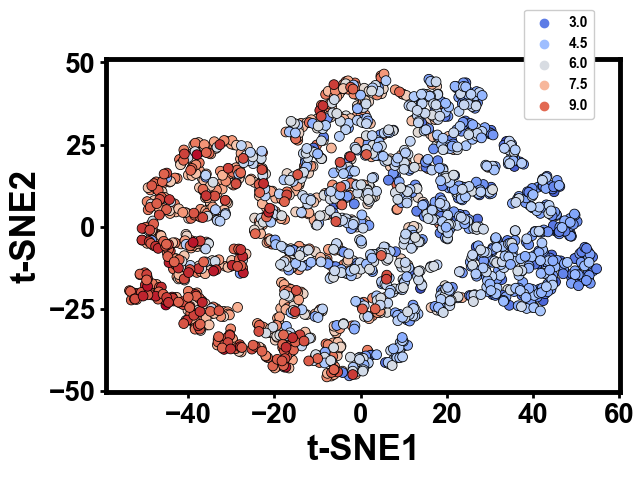

In [32]:
import rdkit.Chem.rdchem as rdchem
fig, ax = plt.subplots(figsize=(8*0.8, 6*0.8))
palette = sns.color_palette("coolwarm", as_cmap=True)
sns.scatterplot(x='tsne1', y='tsne2', data=gen_SMILES, hue=(gen_SMILES['pred_gap']), edgecolor='black',
                palette=palette, alpha=1, s=50)

plt.legend(fontsize=10, framealpha=1, loc='lower left', bbox_to_anchor=(0.8, 0.8))
#plt.legend(fontsize=10)
ax.tick_params(width=2, length=4)
plt.xlabel('t-SNE1', fontsize=25, fontweight='bold')
plt.ylabel('t-SNE2', fontsize=25, fontweight='bold')
#plt.xlim(-10, 10)
#plt.ylim(-10, 10)
ax.tick_params(axis='both', which='major', labelsize=20)

plt.tight_layout()
plt.savefig("./gen_Concat_dist_tsne.png", dpi=300)

In [33]:
gen_SMILES

,SMILES,des_gap,pred_gap,Err_pred_des,tsne1,tsne2,SMILES_HA,gap_group
0,CCCC1CCOC(C=O)C1C,6.8140,6.566881,0.036266,-50.243780,-0.608514,12,2.0
1,CCC1CCCCCCCCCCCCN1,6.0845,7.366741,0.210739,-36.511917,10.960466,16,2.0
2,CC1CCCCCCCCCCCCOC1C,9.7150,8.998064,0.073797,-48.710700,-18.071547,17,3.0
3,CCCCC(C)OC(C)CCC(C)CC,9.0040,8.986472,0.001947,-39.418053,-28.610775,15,3.0
4,CCN(C)CCC=C1CCCCCC(OC)CC1,4.7920,6.687652,0.395587,-3.251199,16.774555,18,2.0
...,...,...,...,...,...,...,...,...
1921,CCCCCC1CCC2CCCC1CCC2,8.8110,9.127287,0.035897,-49.688500,-16.247322,16,3.0
1922,CCCC1CCCC(CC)CCCCCC(C)C1,9.6550,9.801198,0.015142,-44.607740,-23.096447,18,3.0
1923,C#CCCCC(C)CCC(C)CCCCC,9.0886,9.075156,0.001479,-39.705130,-24.631184,16,3.0
1924,CCCCCCC(C)O,9.6300,9.109724,0.054027,-6.193975,-43.544370,9,3.0


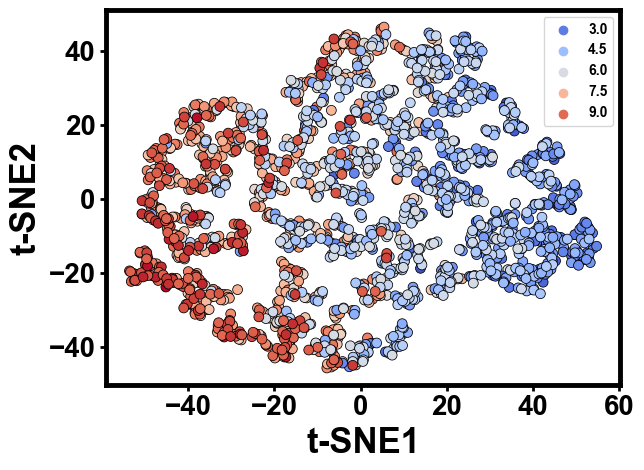

In [34]:
import rdkit.Chem.rdchem as rdchem
fig, ax = plt.subplots(figsize=(8*0.8, 6*0.8))
palette = sns.color_palette("coolwarm", as_cmap=True)
sns.scatterplot(x='tsne1', y='tsne2', data=gen_SMILES, hue=(gen_SMILES['pred_gap']), edgecolor='black',
                palette=palette, alpha=1, s=50)

#plt.legend(['f', 'd', 'dd', 'ddd', 'dddd'], fontsize=15, framealpha=1, loc='lower left', bbox_to_anchor=(0.9, 0.75))
plt.legend(fontsize=10)
ax.tick_params(width=2, length=4)
plt.xlabel('t-SNE1', fontsize=25, fontweight='bold')
plt.ylabel('t-SNE2', fontsize=25, fontweight='bold')
#plt.xlim(-10, 10)
#plt.ylim(-10, 10)
ax.tick_params(axis='both', which='major', labelsize=20)

plt.tight_layout()
plt.savefig("./gen_Concat_dist_tsne.png", dpi=300)

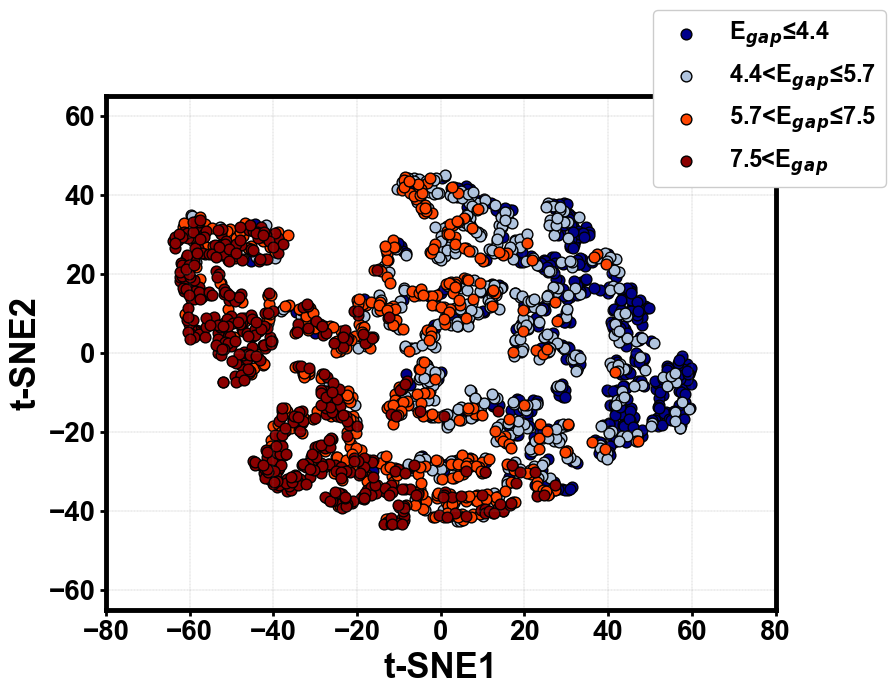

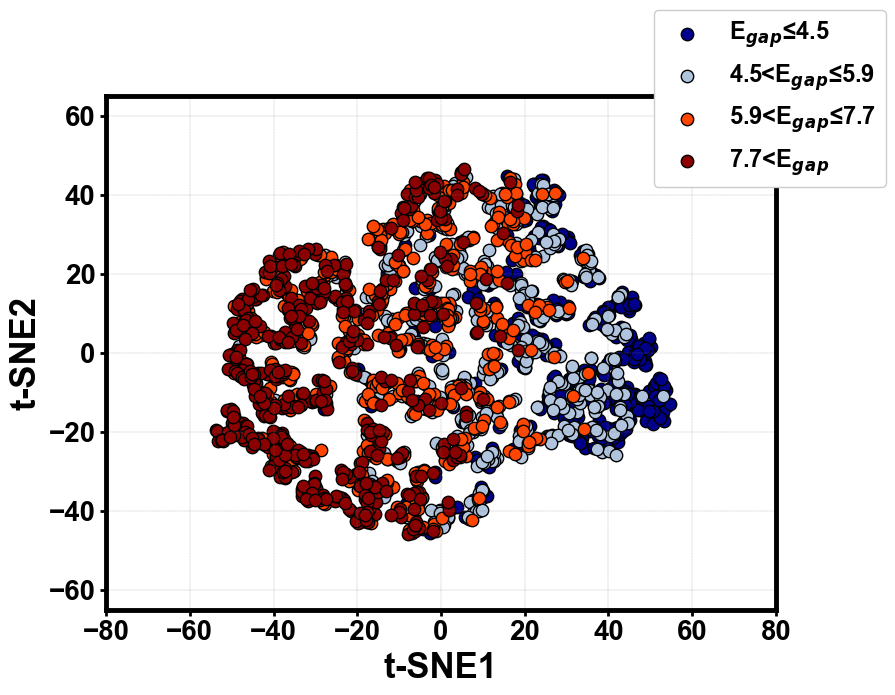

In [35]:
# tsne1 vs. tsne 2 train

plt.close()
mpl.rcParams['axes.linewidth'] = 3.5
fig, ax = plt.subplots(figsize=(9, 7))
ax.tick_params(axis='both', which='major', labelsize=20)

mpl.rcParams['axes.linewidth'] = 3.5
for i, c, label in zip(target_ids, colors, group_names):
    plt.scatter(train_SMILES['tsne1'][y_class == i], 
                train_SMILES['tsne2'][y_class == i],  
                alpha=1, s=60, c=c, label=label, edgecolors='black')
plt.legend(fontsize=17, framealpha=1, loc='lower left', bbox_to_anchor=(0.8, 0.8))
ax.tick_params(width=2, length=4)
plt.xlabel('t-SNE1', fontsize=25, fontweight='bold')
plt.ylabel('t-SNE2', fontsize=25, fontweight='bold')
plt.xlim(-80, 80)
plt.ylim(-65, 65)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.2)
plt.tight_layout()
plt.savefig("./train_concat_dist_tsne.png", dpi=500)
plt.show()
# tsne1 vs. tsne2 gen.

plt.close()
fig, ax = plt.subplots(figsize =(9, 7))
ax.tick_params(axis='both', which='major', labelsize=20)
mpl.rcParams['axes.linewidth'] = 3.5
for i, c, label in zip(target_ids, colors, group_names_gen):
    plt.scatter(gen_SMILES['tsne1'][y_class_val == i], 
                gen_SMILES['tsne2'][y_class_val == i], 
                alpha=1, s=80, c=c, label=label, edgecolors='black')
#plt.legend(fontsize=12)
plt.legend(fontsize=17, framealpha=1, loc='lower left', bbox_to_anchor=(0.8, 0.8))
ax.tick_params(width=2, length=4)
plt.xlabel('t-SNE1', fontsize=25, fontweight='bold')
plt.ylabel('t-SNE2', fontsize=25, fontweight='bold')
plt.xlim(-80, 80)
plt.ylim(-65, 65)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.2)
plt.tight_layout()
plt.savefig("./gen_Concat_dist_tsne.png", dpi=500)

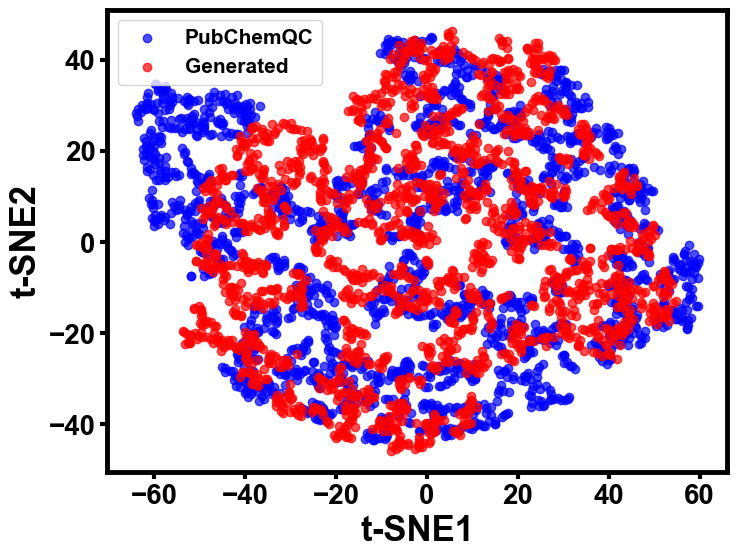

In [36]:
# PCA1 vs. PCA2 gen and train
plt.close()
fig, ax = plt.subplots(figsize =(8, 6))
ax.tick_params(axis='both', which='major', labelsize=20)
mpl.rcParams['axes.linewidth'] = 3.5
plt.scatter(train_SMILES['tsne1'], train_SMILES['tsne2'], edgecolor=None, alpha=0.7, c='blue', label='PubChemQC')
ax.tick_params(width=3, length=5)
plt.xlabel('t-SNE1', fontsize=25, weight='bold')
plt.ylabel('t-SNE2', fontsize=25, weight='bold')
#plt.close()
plt.scatter(gen_SMILES['tsne1'], gen_SMILES['tsne2'], alpha=0.7, c='red', edgecolor=None, label='Generated')
plt.legend(fontsize=15, loc='upper left')
plt.savefig("./genvstrain_tsne1tsne2.png".format(len(preds)), bbox_inches='tight', dpi=500)

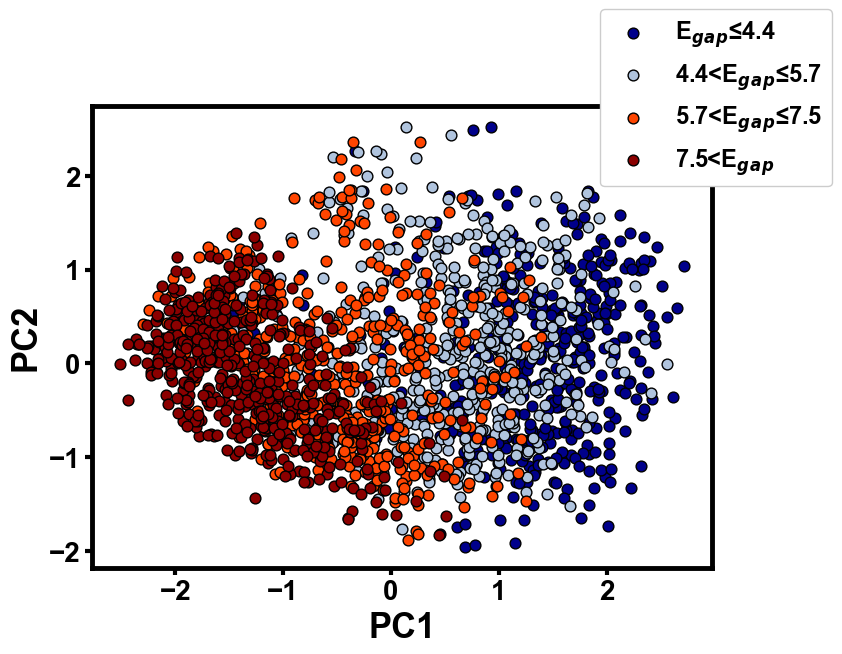

In [37]:
# PCA1 vs. PCA2 gen and train
plt.close()
fig, ax = plt.subplots(figsize =(8, 6))
ax.tick_params(axis='both', which='major', labelsize=20)
mpl.rcParams['axes.linewidth'] = 3.5

for i, c, label in zip(target_ids, colors, group_names):
    plt.scatter(X_concat_train_pca[:, 0][y_class == i], 
                X_concat_train_pca[:, 1][y_class == i],  
                alpha=1, s=60, c=c, label=label, edgecolors='black')
    
ax.tick_params(width=3, length=5)
plt.xlabel('PC1', fontsize=25, weight='bold')
plt.ylabel('PC2', fontsize=25, weight='bold')
#plt.close()
plt.legend(fontsize=17, framealpha=1, loc='lower left', bbox_to_anchor=(0.8, 0.8))
plt.savefig("./train_pc1pc2_gapcolor.png".format(len(preds)), bbox_inches='tight', dpi=500)

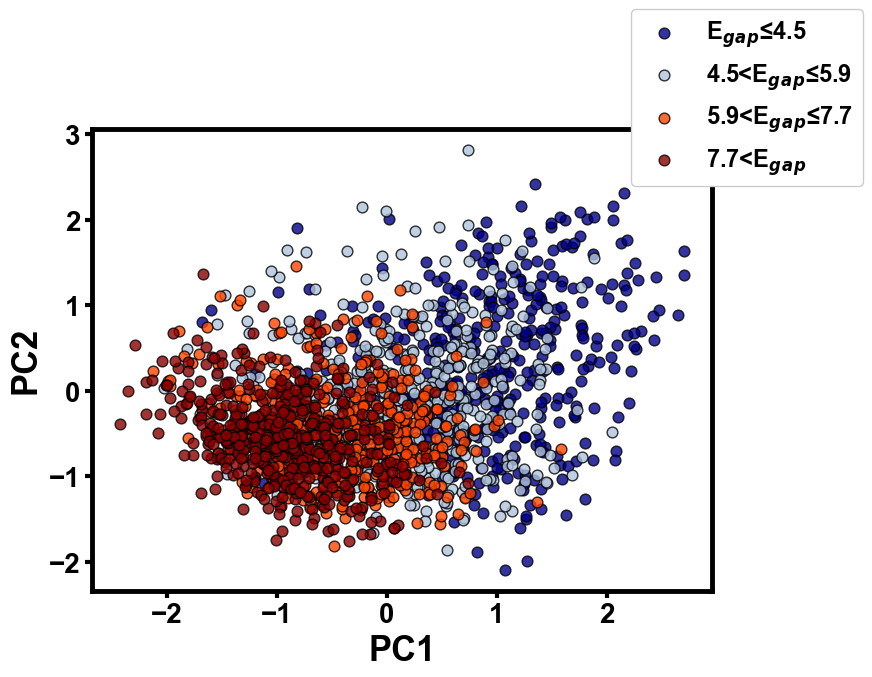

In [38]:
# PCA1 vs. PCA2 gen and train
plt.close()
fig, ax = plt.subplots(figsize =(8, 6))
ax.tick_params(axis='both', which='major', labelsize=20)
mpl.rcParams['axes.linewidth'] = 3.5

for i, c, label in zip(target_ids, colors, group_names_gen):
    plt.scatter(X_concat_test_pca[:, 0][y_class_val == i], 
                X_concat_test_pca[:, 1][y_class_val == i],  
                alpha=0.8, s=60, c=c, label=label, edgecolors='black')
    
ax.tick_params(width=3, length=5)
plt.xlabel('PC1', fontsize=25, weight='bold')
plt.ylabel('PC2', fontsize=25, weight='bold')
#plt.close()
plt.legend(fontsize=17, framealpha=1, loc='lower left', bbox_to_anchor=(0.85, 0.85))
plt.savefig("./gen_pc1pc2_gapcolor.png".format(len(preds)), bbox_inches='tight', dpi=500)

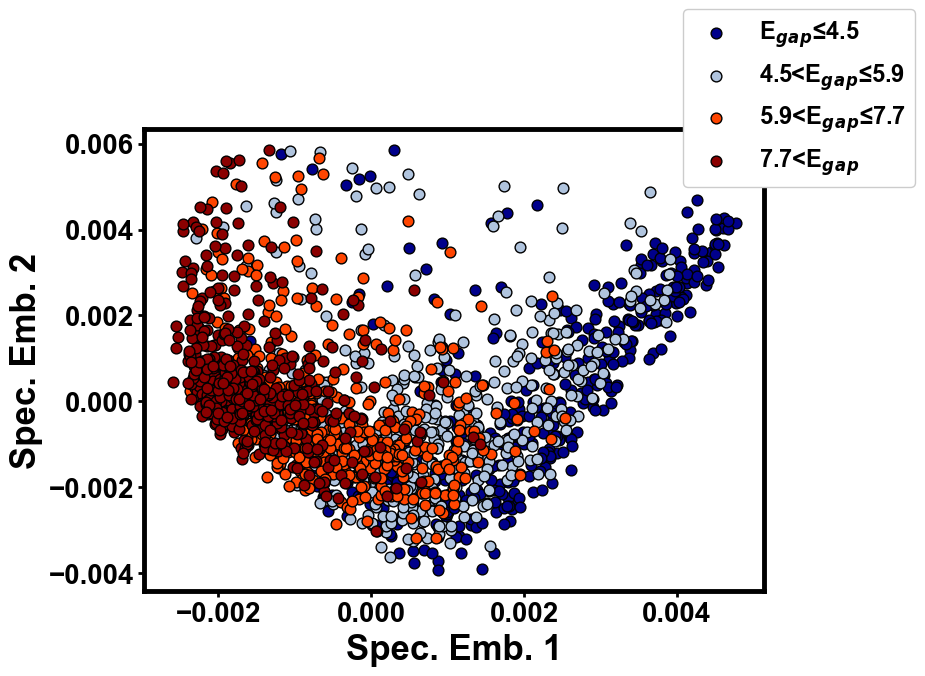

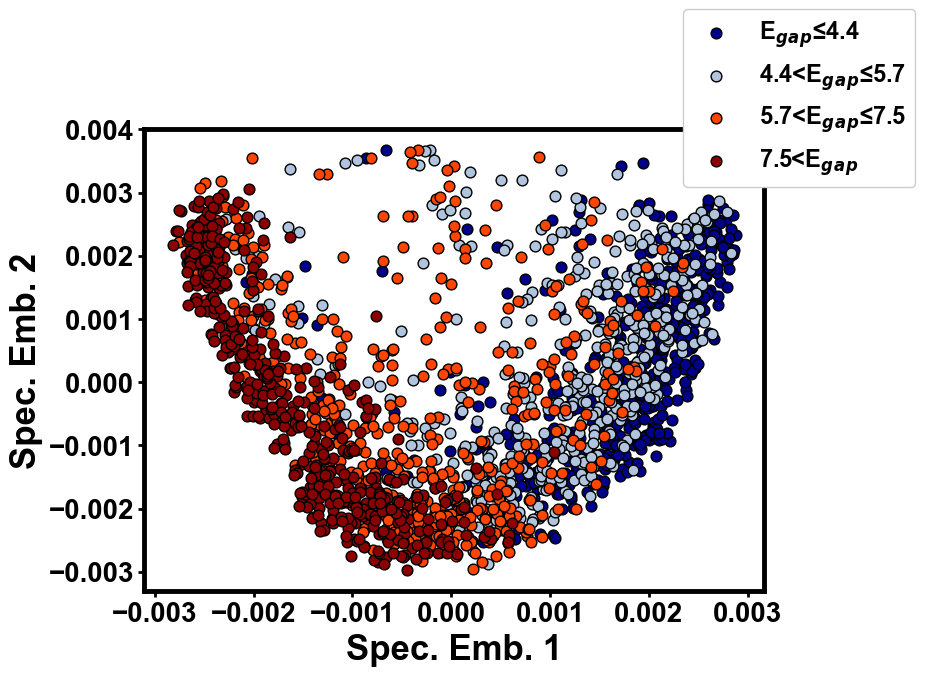

In [48]:
# SpectralEmbedding dimension reduction
embedding = SpectralEmbedding(n_components=2, n_jobs=-1)
X_concat_train_SpectralEmbedding = embedding.fit_transform(X_Concat_train)
X_concat_test_SpectralEmbedding = embedding.fit_transform(X_Concat_test)

plt.close()
fig, ax = plt.subplots(figsize =(8, 6))
ax.tick_params(axis='both', which='major', labelsize=20)
mpl.rcParams['axes.linewidth'] = 3.5
for i, c, label in zip(target_ids, colors, group_names_gen):
            plt.scatter(X_concat_test_SpectralEmbedding[y_class_val == i, 0],
                        X_concat_test_SpectralEmbedding[y_class_val == i, 1],
                        c=c, label=label, alpha=1, s=60, edgecolors='black')
plt.legend(fontsize=17, framealpha=1, loc='lower left', bbox_to_anchor=(0.85, 0.85))
ax.tick_params(width=2, length=4)
plt.xlabel('Spec. Emb. 1', fontsize=25, fontweight='bold')
plt.ylabel('Spec. Emb. 2', fontsize=25, fontweight='bold')
plt.savefig("test_conc_dist_SpectralEmbedding.png", bbox_inches='tight', dpi=300)
plt.show()

plt.close()
fig, ax = plt.subplots(figsize =(8, 6))
ax.tick_params(axis='both', which='major', labelsize=20)
mpl.rcParams['axes.linewidth'] = 3.5
for i, c, label in zip(target_ids, colors, group_names):
            plt.scatter(X_concat_train_SpectralEmbedding[y_class == i, 0],
                        X_concat_train_SpectralEmbedding[y_class == i, 1],
                       c=c, label=label, alpha=1, s=60, edgecolors='black')
plt.legend(fontsize=17, framealpha=1, loc='lower left', bbox_to_anchor=(0.85, 0.85))
ax.tick_params(width=2, length=4)
plt.xlabel('Spec. Emb. 1', fontsize=25, fontweight='bold')
plt.ylabel('Spec. Emb. 2', fontsize=25, fontweight='bold')
plt.savefig("train_conc_dist_SpectralEmbedding.png", bbox_inches='tight', dpi=300)
plt.show()